# Processing pipeline

In [7]:
import sys
sys.path.insert(1, '/Users/jakoliendenhollander/capstone/capstone')
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime

from datetime import timedelta
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import residuals_plot
from sklearn.inspection import plot_partial_dependence

import tidy_functions.load_data
import tidy_functions.clean_data
import tidy_functions.merge_data_model
import tidy_functions.feature_engineering

warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None) # To display all columns

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Read in data

In [9]:
# Reading in survey data from csv into a dictionary of dataframes.
dfs_country = tidy_functions.load_data.load_survey_data("/Users/jakoliendenhollander/capstone/capstone/data/CMU_Global_data/Full_Survey_Data/country/smooth/", "country")

# Concatenating individuals dataframes from the dictionary into one dataframe for regions.
survey_data = pd.concat(dfs_country, ignore_index=True)

# Corona stats
covid_cases = pd.read_csv("/Users/jakoliendenhollander/capstone/capstone/data/corona_stats_14days.csv")
print('Read in covid data completed.')

# Mask wearing requirements
mask_wearing_requirements = pd.read_csv("/Users/jakoliendenhollander/capstone/capstone/data/data-nbhtq.csv")
print('Read in mask wearing requirements data completed.')

Read in survey data completed.
Read in covid data completed.
Read in mask wearing requirements data completed.


## Cleaning data

In [10]:
# Survey data
survey_data = tidy_functions.clean_data.delete_other_gender(survey_data)
survey_data = tidy_functions.clean_data.deal_with_NaNs_masks(survey_data)

# Corona stats
covid_cases = tidy_functions.clean_data.deal_with_NaNs_corona_stats(covid_cases)

# Mask wearing requirements
mask_wearing_requirements = tidy_functions.clean_data.prepare_mask_req(mask_wearing_requirements)
mask_wearing_requirements = tidy_functions.clean_data.dummies_mask_req(mask_wearing_requirements)
mask_wearing_requirements = tidy_functions.clean_data.dummies_public_mask_req(mask_wearing_requirements)
mask_wearing_requirements = tidy_functions.clean_data.dummies_indoors_mask_req(mask_wearing_requirements)
mask_wearing_requirements = tidy_functions.clean_data.dummies_transport_mask_req(mask_wearing_requirements)
mask_wearing_requirements = tidy_functions.clean_data.data_types_mask_req(mask_wearing_requirements)

# HDI
hdi_data = tidy_functions.clean_data.rename_hdi_countries("/Users/jakoliendenhollander/capstone/capstone/data/","hdro_statistical_data_tables_1_15_d1_d5.xlsx")
dict_hdi = tidy_functions.clean_data.create_hdi_dict(hdi_data)
dict_hdi_levels = tidy_functions.clean_data.create_hdi_levels_dict(hdi_data)

NaNs before update: 152923
NaNs after update: 0
Updated NaNs in wear_mask_all_time.
NaNs removed.
Step 1 of cleaning requirements completed.
Step 2 of cleaning requirements completed.
Step 3 of cleaning requirements completed.
Step 4 of cleaning requirements completed.
Step 5 of cleaning requirements completed.
Step 6 of cleaning requirements completed.
Creating dictionaries for hdi completed.
Creating dictionaries for hdi-levels completed.


## Merging data

In [11]:
covid_merge = tidy_functions.merge_data_model.merge_corona_stats(survey_data,covid_cases)
requirements_merge = tidy_functions.merge_data_model.merge_mask_req(covid_merge,mask_wearing_requirements)
hdi_merge = tidy_functions.merge_data_model.create_hdi_columns(requirements_merge, dict_hdi, dict_hdi_levels)

Merging corona stats completed.
Merging mask wearing requirements completed.
Creating hdi list completed.
Creating hdi-level list completed.


## Feature engineering

In [12]:
date_fixed = tidy_functions.feature_engineering.insert_month(hdi_merge)
requirement_date = tidy_functions.feature_engineering.add_requirement_by_date(date_fixed)

Month column created.
Feature engineering completed.


In [13]:
df = requirement_date.copy()

## Data selection

In [14]:
df = df[df["age_bucket"]=="overall"]
df = df[df["gender"]=="overall"]

In [15]:
date = ["date"]

columns_general = ["iso_code", "hdi", "median_age"]

columns_general_no_iso = ["hdi", "median_age"]

columns_social_distancing = ["smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted", "smoothed_pct_ate_outside_home_weighted", 
                             "smoothed_pct_attended_public_event_weighted", "smoothed_pct_used_public_transit_weighted", 
                             "smoothed_pct_direct_contact_with_non_hh_weighted", "smoothed_pct_no_public_weighted"]

columns_mask_wearing = ["smoothed_pct_wear_mask_all_time_weighted", "smoothed_pct_wear_mask_most_time_weighted"]

columns_mask_req = ["cur_mask_recommended", "cur_mask_not_required", "cur_mask_not_required_recommended", "cur_mask_not_required_universal", 
                    "cur_mask_required_part_country", "cur_mask_everywhere_in_public", "cur_mask_public_indoors", "cur_mask_public_transport"]

columns_past = ["total_cases_per_million","previous_7days"]

columns_pred = ["next_14days"]

columns_interest = date + columns_general + columns_social_distancing + columns_mask_wearing + columns_mask_req + columns_past + columns_pred


In [16]:
df_select = df[columns_interest]

In [17]:
df_time = df_select.copy()

In [18]:
# convert columns from object to numeric
df_time.previous_7days = pd.to_numeric(df_time.previous_7days, errors='coerce')
df_time.next_14days = pd.to_numeric(df_time.next_14days, errors='coerce')

In [19]:
# sort data frame by time
df_time = df_time.sort_values('date')

## Overall model

In [20]:
# drop date and iso code column
df_no_date = df_time.drop(["iso_code","date"], axis=1)

In [21]:
# define X and y
X = df_no_date.drop("next_14days", axis=1)
y = df_no_date["next_14days"]

In [22]:
# divide the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17016, 21) (4254, 21) (17016,) (4254,)


In [23]:
model = RandomForestRegressor(criterion='mae')

In [24]:
# define the target transform wrapper 
wrapped_model = TransformedTargetRegressor(regressor=model,transformer=MinMaxScaler()) 
# use the target transform wrapper 
wrapped_model.fit(X_train, y_train) 
yhat = wrapped_model.predict(X_test)

In [25]:
# evaluate the model
print('mae:',metrics.mean_absolute_error(y_test, yhat))
print('mape:',mean_absolute_percentage_error(y_test, yhat))

mae: 107.49702310648813
mape: 3.7053800662706817


## Making predictions

In [26]:
def predict_cases(iso_code,date):
    what = df_time.loc[(df_time["iso_code"]==iso_code) & (df_time["date"]==date)]
    what = what[columns_interest]
    true_value = what["next_14days"].values
    
    what.drop(["iso_code","date","next_14days"], axis=1, inplace=True)
    prediction = wrapped_model.predict(what)
    
    return str(true_value)[1:-1],str(prediction)[1:-1]

### Lebanon

In [27]:
dates = []
true_values = [] 
predicted_values = []

for i in df_time.date.unique():
    i = str(i).split('T')[0]
    dates.append(i)
    true,prediction = predict_cases('LBN', i)
    true_values.append(true)
    predicted_values.append(prediction)

In [28]:
lebanese_data = pd.DataFrame([], columns=['date','true_value','predicted_value'])
lebanese_data['date'] = dates
lebanese_data['true_value'] = true_values
lebanese_data['predicted_value'] = predicted_values

In [29]:
lebanese_data['date'] = pd.to_datetime(lebanese_data.date, errors='coerce')
lebanese_data['true_value'] = pd.to_numeric(lebanese_data.true_value, errors='coerce')
lebanese_data['predicted_value'] = pd.to_numeric(lebanese_data.predicted_value, errors='coerce')

In [30]:
pivot_lebanese_data = lebanese_data.groupby(['date'])[['true_value','predicted_value']].mean()
pivot_lebanese_data = pivot_lebanese_data.stack().reset_index()
pivot_lebanese_data = pivot_lebanese_data.rename(columns={"level_1":"value_type",0: "cases"})

In [52]:
lebanese_mask = (pivot_lebanese_data.date < pd.to_datetime('2020-11-01'))
pivot_lebanese_data = pivot_lebanese_data.loc[lebanese_mask]

### Germany

In [31]:
dates = []
true_values = [] 
predicted_values = []

for i in df_time.date.unique():
    i = str(i).split('T')[0]
    dates.append(i)
    true,prediction = predict_cases('DEU', i)
    true_values.append(true)
    predicted_values.append(prediction)

In [32]:
german_data = pd.DataFrame([], columns=['date','true_value','predicted_value'])
german_data['date'] = dates
german_data['true_value'] = true_values
german_data['predicted_value'] = predicted_values

In [33]:
german_data['date'] = pd.to_datetime(german_data.date, errors='coerce')
german_data['true_value'] = pd.to_numeric(german_data.true_value, errors='coerce')
german_data['predicted_value'] = pd.to_numeric(german_data.predicted_value, errors='coerce')

In [34]:
pivot_german_data = german_data.groupby(['date'])[['true_value','predicted_value']].mean()
pivot_german_data = pivot_german_data.stack().reset_index()
pivot_german_data = pivot_german_data.rename(columns={"level_1":"value_type",0: "cases"})

In [53]:
german_mask = (pivot_german_data.date < pd.to_datetime('2020-11-01'))
pivot_german_data = pivot_german_data.loc[german_mask]

### Taiwan

In [35]:
dates = []
true_values = [] 
predicted_values = []

for i in df_time.date.unique():
    i = str(i).split('T')[0]
    dates.append(i)
    true,prediction = predict_cases('TWN', i)
    true_values.append(true)
    predicted_values.append(prediction)

In [36]:
taiwanese_data = pd.DataFrame([], columns=['date','true_value','predicted_value'])
taiwanese_data['date'] = dates
taiwanese_data['true_value'] = true_values
taiwanese_data['predicted_value'] = predicted_values

In [37]:
taiwanese_data['date'] = pd.to_datetime(taiwanese_data.date, errors='coerce')
taiwanese_data['true_value'] = pd.to_numeric(taiwanese_data.true_value, errors='coerce')
taiwanese_data['predicted_value'] = pd.to_numeric(taiwanese_data.predicted_value, errors='coerce')

In [38]:
pivot_taiwanese_data = taiwanese_data.groupby(['date'])[['true_value','predicted_value']].mean()
pivot_taiwanese_data = pivot_taiwanese_data.stack().reset_index()
pivot_taiwanese_data = pivot_taiwanese_data.rename(columns={"level_1":"value_type",0: "cases"})

In [55]:
taiwanese_mask = (pivot_taiwanese_data.date < pd.to_datetime('2020-11-01'))
pivot_taiwanese_data = pivot_taiwanese_data.loc[taiwanese_mask]

### Mexico

In [39]:
dates = []
true_values = [] 
predicted_values = []

for i in df_time.date.unique():
    i = str(i).split('T')[0]
    dates.append(i)
    true,prediction = predict_cases('MEX', i)
    true_values.append(true)
    predicted_values.append(prediction)

In [40]:
mexican_data = pd.DataFrame([], columns=['date','true_value','predicted_value'])
mexican_data['date'] = dates
mexican_data['true_value'] = true_values
mexican_data['predicted_value'] = predicted_values

In [41]:
mexican_data['date'] = pd.to_datetime(mexican_data.date, errors='coerce')
mexican_data['true_value'] = pd.to_numeric(mexican_data.true_value, errors='coerce')
mexican_data['predicted_value'] = pd.to_numeric(mexican_data.predicted_value, errors='coerce')

In [42]:
pivot_mexican_data = mexican_data.groupby(['date'])[['true_value','predicted_value']].mean()
pivot_mexican_data = pivot_mexican_data.stack().reset_index()
pivot_mexican_data = pivot_mexican_data.rename(columns={"level_1":"value_type",0: "cases"})

In [54]:
mexican_mask = (pivot_mexican_data.date < pd.to_datetime('2020-11-01'))
pivot_mexican_data = pivot_mexican_data.loc[mexican_mask]

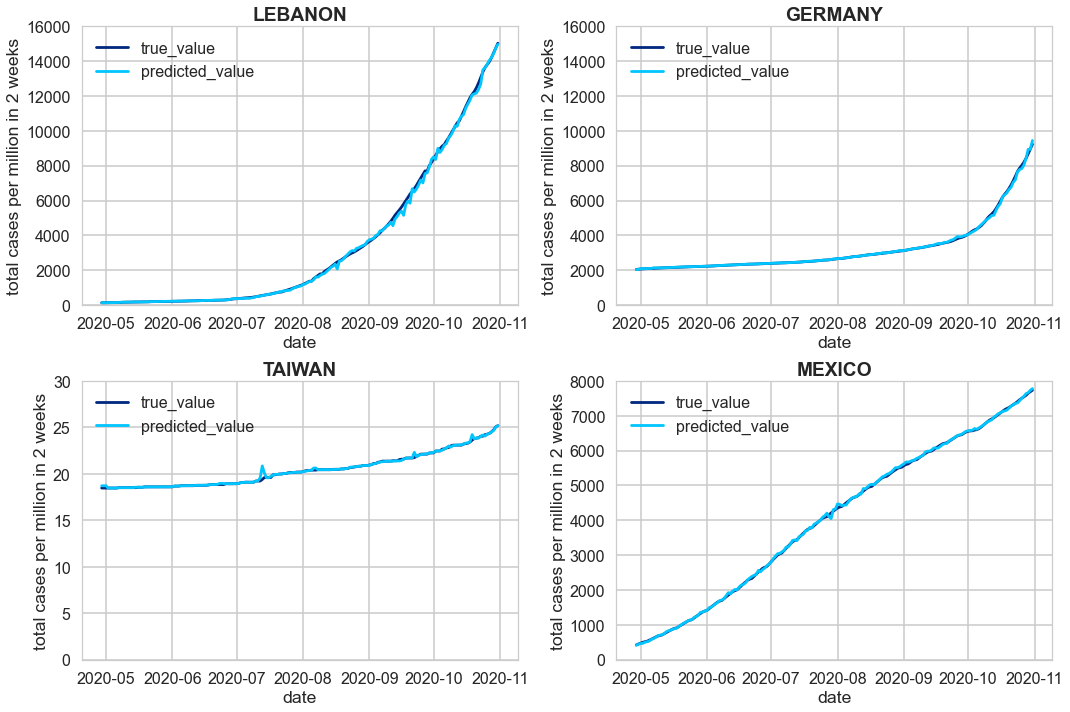

In [56]:
# Plotting settings
sns.set_style("whitegrid")
plt.style.use('seaborn-poster')
slides_palette = ["#00287f", "#00c5ff"]
sns.set_palette(slides_palette)
f, axes = plt.subplots(2, 2, figsize=(15,10))


g1 = sns.lineplot(data=pivot_lebanese_data, x='date', y='cases', hue='value_type', ax=axes[0][0]);
g1.set_title('LEBANON', weight='bold');
g1.set_xlabel('date');
g1.set_ylabel('total cases per million in 2 weeks');
g1.set_ylim(0,16000)
g1.legend().set_title('');
g1.legend(loc='upper left');

g2 = sns.lineplot(data=pivot_german_data, x='date', y='cases', hue='value_type', ax=axes[0][1]);
g2.set_title('GERMANY', weight='bold');
g2.set_xlabel('date');
g2.set_ylabel('total cases per million in 2 weeks');
g2.set_ylim(0,16000)
g2.legend().set_title('');
g2.legend(loc='upper left');

g3 = sns.lineplot(data=pivot_taiwanese_data, x='date', y='cases', hue='value_type', ax=axes[1][0]);
g3.legend().set_title('');
g3.set_title('TAIWAN', weight='bold');
g3.set_xlabel('date');
g3.set_ylabel('total cases per million in 2 weeks');
g3.set_ylim(0,30)
g3.legend().set_title('');
g3.legend(loc='upper left');

g4 = sns.lineplot(data=pivot_mexican_data, x='date', y='cases', hue='value_type', ax=axes[1][1]);
g4.set_title('MEXICO', weight='bold');
g4.set_xlabel('date');
g4.set_ylabel('total cases per million in 2 weeks');
g4.set_ylim(0,8000)
g4.legend().set_title('');
g4.legend(loc='upper left');

plt.tight_layout()

In [ ]:
# plot the residuals
viz = residuals_plot(RandomForestRegressor(criterion='mae'), X_train, y_train, X_test, y_test)

In [ ]:
# make feature dependence plots
features = ["hdi", "median_age", "smoothed_pct_wear_mask_all_time_weighted", "smoothed_pct_wear_mask_most_time_weighted",
            "cur_mask_recommended", "cur_mask_not_required", "cur_mask_not_required_recommended", 
            "cur_mask_not_required_universal", "cur_mask_required_part_country", "cur_mask_everywhere_in_public",
            "cur_mask_public_indoors", "cur_mask_public_transport","total_cases_per_million","previous_7days"]

plot_partial_dependence(wrapped_model, X_train, features,
                        n_jobs=3, grid_resolution=20)
fig = plt.gcf()
fig.suptitle('Partial dependence of covid-19 cases on features.')
fig.subplots_adjust(hspace=0.5)

## Answering research questions

In [ ]:
# create a pivot table with the overall percentages of wearing mask all time per country
pivot_mask_all_time = df_time.groupby(['iso_code'])[['smoothed_pct_wear_mask_all_time_weighted']].mean()
pivot_mask_all_time = pivot_mask_all_time.stack().reset_index()
pivot_mask_all_time.drop('level_1', axis=1, inplace=True)
pivot_mask_all_time = pivot_mask_all_time.rename(columns={0: "mask_all_time"})

# split dataset into countries with more and those with less mask wearing
masks_all_more = pivot_mask_all_time[pivot_mask_all_time.mask_all_time >= 50]
masks_all_less = pivot_mask_all_time[pivot_mask_all_time.mask_all_time < 50]
print('all',masks_all_more.iso_code.nunique())
print('not all',masks_all_less.iso_code.nunique())

In [ ]:
# list of social distancing measures that are not well adhered to when the values are high
columns_soc_dist_bad = ["smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted", "smoothed_pct_ate_outside_home_weighted", 
                             "smoothed_pct_attended_public_event_weighted", "smoothed_pct_used_public_transit_weighted", 
                             "smoothed_pct_direct_contact_with_non_hh_weighted"]

In [ ]:
# create a pivot table with the overall percentages per measure per country
pivot_soc_dist = df_time.groupby(['iso_code'])[columns_soc_dist_bad].mean()
pivot_soc_dist = pivot_soc_dist.stack().reset_index()
pivot_soc_dist = pivot_soc_dist.rename(columns={0: "percentage"})

# create a pivot table with the overall percentages over all measures per country
pivot_soc_dist_overall = pivot_soc_dist.groupby(['iso_code'])[['percentage']].mean()
pivot_soc_dist_overall = pivot_soc_dist_overall.stack().reset_index()
pivot_soc_dist_overall.drop('level_1', axis=1, inplace=True)
pivot_soc_dist_overall = pivot_soc_dist_overall.rename(columns={0: "percentage"})

# split dataset into countries that adhere more and less to social distancing measures
soc_dist_more = pivot_soc_dist_overall[pivot_soc_dist_overall.percentage < 34]
soc_dist_less = pivot_soc_dist_overall[pivot_soc_dist_overall.percentage >= 34]
print('most',soc_dist_more.iso_code.nunique())
print('not_most',soc_dist_less.iso_code.nunique())

In [ ]:
# create a list of isocodes of countries that adhere well to mask wearing and social distancing (good_guys) and of those who do not (bad_guys)
good_guys = list(set(masks_all_more['iso_code']).intersection(set(soc_dist_more['iso_code'])))
bad_boys = list(set(masks_all_less['iso_code']).intersection(set(soc_dist_less['iso_code'])))

In [ ]:
# select rows from the dataframe based on iso codes of adhering and not adhering countries
adhering = df_time[df_time["iso_code"].isin(good_guys)]
not_adhering = df_time[df_time["iso_code"].isin(bad_boys)]

## Adhering model

In [ ]:
# drop iso code and date columns
df_adhering = adhering.drop(["iso_code","date"], axis=1)

In [ ]:
# define X and y
adh_X = df_adhering.drop("next_14days", axis=1)
adh_y = df_adhering["next_14days"]

In [ ]:
# divide the data into train and test data
adh_X_train, adh_X_test, adh_y_train, adh_y_test = train_test_split(adh_X, adh_y, test_size=0.2, random_state=42)
print(adh_X_train.shape, adh_X_test.shape, adh_y_train.shape, adh_y_test.shape)

In [ ]:
model = RandomForestRegressor(criterion='mae')

In [ ]:
# define the target transform wrapper 
adh_wrapped_model = TransformedTargetRegressor(regressor=model,transformer=MinMaxScaler()) 
# use the target transform wrapper 
adh_wrapped_model.fit(adh_X_train, adh_y_train) 
adh_yhat = adh_wrapped_model.predict(adh_X_test)

In [ ]:
# evaluate the model
print('mae:',metrics.mean_absolute_error(adh_y_test, adh_yhat))
print('mape:',mean_absolute_percentage_error(adh_y_test, adh_yhat))

In [ ]:
# plot the residuals
viz = residuals_plot(RandomForestRegressor(criterion='mae'), adh_X_train, adh_y_train, adh_X_test, adh_y_test)

## Not adhering model

In [ ]:
# drop iso_code and date columns
df_not_adhering = not_adhering.drop(["iso_code","date"], axis=1)

In [ ]:
# define X and y
not_adh_X = df_not_adhering.drop("next_14days", axis=1)
not_adh_y = df_not_adhering["next_14days"]

In [ ]:
# divide the data into train and test data
not_adh_X_train, not_adh_X_test, not_adh_y_train, not_adh_y_test = train_test_split(not_adh_X, not_adh_y, test_size=0.2, random_state=42)
print(not_adh_X_train.shape, not_adh_X_test.shape, not_adh_y_train.shape, not_adh_y_test.shape)

In [ ]:
model = RandomForestRegressor(criterion='mae')

In [ ]:
# define the target transform wrapper 
not_adh_wrapped_model = TransformedTargetRegressor(regressor=model,transformer=MinMaxScaler()) 
# use the target transform wrapper 
not_adh_wrapped_model.fit(not_adh_X_train, not_adh_y_train) 
not_adh_yhat = not_adh_wrapped_model.predict(not_adh_X_test)

In [ ]:
# evaluate the model
print('mae:',metrics.mean_absolute_error(not_adh_y_test, not_adh_yhat))
print('mape:',mean_absolute_percentage_error(not_adh_y_test, not_adh_yhat))

In [ ]:
# plot the residuals
viz = residuals_plot(RandomForestRegressor(criterion='mae'), not_adh_X_train, not_adh_y_train, not_adh_X_test, not_adh_y_test)

# Testing the model

In [ ]:
def make_prediction(iso_code,date):
    pred = df_time.loc[(df_time["iso_code"]==iso_code) & (df_time["date"]==date)]
    pred = pred[columns_interest]
    true_value = pred["next_14days"].values
    pred.drop(["iso_code","date","next_14days"], axis=1, inplace=True)
    pred_overall = wrapped_model.predict(pred)
    pred_adh = adh_wrapped_model.predict(pred)
    pred_not_adh = not_adh_wrapped_model.predict(pred)
    print('true number of cases:',str(true_value)[1:-1])
    print('predicted number of cases:',str(pred_overall)[1:-1])
    print('predicted number of cases if inhabitants adhered to mask wearing and social distancing:',str(pred_adh)[1:-1])
    print('predicted number of cases if inhabitants have not adhered to mask wearing and social distancing:',str(pred_not_adh)[1:-1])

In [ ]:
included = good_guys+bad_boys
excluded = list(set(df_time.iso_code).symmetric_difference(included))

In [ ]:
impossible = ['BHS','UGA','SSD','BHR','CAF']
for i in impossible:
    if i in excluded:
        excluded.remove(i)

In [ ]:
len(excluded)

In [ ]:
for i in excluded:
    print(i)
    make_prediction(i,"2020-07-16")

## Second approach
Filling out custom numbers

In [57]:
def predict_scenario(iso_code,date,pc_mask_wearing,pc_social_distancing):
    scenario = df_time.loc[(df_time["iso_code"]==iso_code) & (df_time["date"]==date)]
    scenario = scenario[columns_interest]
    
    true_value = scenario["next_14days"].values
    
    scenario.drop(["iso_code","date","next_14days"], axis=1, inplace=True)
    
    scenario_adhering = scenario.copy()
    scenario_adhering[["smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted",
                 "smoothed_pct_ate_outside_home_weighted", "smoothed_pct_attended_public_event_weighted",
                 "smoothed_pct_used_public_transit_weighted", "smoothed_pct_direct_contact_with_non_hh_weighted"]] = 100-pc_social_distancing
    scenario_adhering["smoothed_pct_wear_mask_all_time_weighted"] = pc_mask_wearing
    
    scenario_not_adhering = scenario.copy()
    scenario_not_adhering[["smoothed_pct_worked_outside_home_weighted", "smoothed_pct_grocery_outside_home_weighted",
                 "smoothed_pct_ate_outside_home_weighted", "smoothed_pct_attended_public_event_weighted",
                 "smoothed_pct_used_public_transit_weighted", "smoothed_pct_direct_contact_with_non_hh_weighted"]] = pc_social_distancing
    scenario_not_adhering["smoothed_pct_wear_mask_all_time_weighted"] = 100-pc_mask_wearing
    
    pred_scenario = wrapped_model.predict(scenario)
    pred_scenario_adhering = wrapped_model.predict(scenario_adhering)
    pred_scenario_not_adhering = wrapped_model.predict(scenario_not_adhering)
    
    #print('true number of cases:',str(true_value)[1:-1]))
    #print('predicted number of cases:',str(pred_scenario)[1:-1])
    #print('predicted number of cases if inhabitants adhered to mask wearing and social distancing:',str(pred_scenario_adhering)[1:-1])
    #print('predicted number of cases if inhabitants have not adhered to mask wearing and social distancing:',str(pred_scenario_not_adhering)[1:-1])
    
    return str(true_value)[1:-1],str(pred_scenario)[1:-1],str(pred_scenario_adhering)[1:-1],str(pred_scenario_not_adhering)[1:-1]

In [40]:
predict_scenario("GBR","2020-09-28",80,80)

('8893.085', '8819.95373', '8781.35048', '8250.46506')

In [ ]:
for i in excluded:
    print(i)
    predict_scenario(i,"2020-07-16",80,80)

### South-Africa

In [58]:
dates = []
true_values = [] 
predicted_values = []
predicted_values_adhering = []
predicted_values_not_adhering = []

for i in df_time.date.unique():
    i = str(i).split('T')[0]
    dates.append(i)
    true,prediction,prediction_adh,prediction_not_adh = predict_scenario('ZAF', i, 80, 80)
    true_values.append(true)
    predicted_values.append(prediction)
    predicted_values_adhering.append(prediction_adh)
    predicted_values_not_adhering.append(prediction_not_adh)

In [59]:
sth_african_data = pd.DataFrame([], columns=['date','true_value','predicted_value','predicted_value_adhering',
                                             'predicted_value_not_adhering'])
sth_african_data['date'] = dates
sth_african_data['true_value'] = true_values
sth_african_data['predicted_value'] = predicted_values
sth_african_data['predicted_value_adhering'] = predicted_values_adhering
sth_african_data['predicted_value_not_adhering'] = predicted_values_not_adhering

In [60]:
sth_african_data['date'] = pd.to_datetime(sth_african_data.date, errors='coerce')
sth_african_data['true_value'] = pd.to_numeric(sth_african_data.true_value, errors='coerce')
sth_african_data['predicted_value'] = pd.to_numeric(sth_african_data.predicted_value, errors='coerce')
sth_african_data['predicted_value_adhering'] = pd.to_numeric(sth_african_data.predicted_value_adhering, errors='coerce')
sth_african_data['predicted_value_not_adhering'] = pd.to_numeric(sth_african_data.predicted_value_not_adhering, errors='coerce')

In [61]:
pivot_sth_african_data = sth_african_data.groupby(['date'])[['true_value','predicted_value','predicted_value_adhering',
                                                            'predicted_value_not_adhering']].mean()
pivot_sth_african_data = pivot_sth_african_data.stack().reset_index()
pivot_sth_african_data = pivot_sth_african_data.rename(columns={"level_1":"value_type",0: "cases"})

In [62]:
sth_african_mask = (pivot_sth_african_data.date < pd.to_datetime('2020-11-01'))
pivot_sth_african_data = pivot_sth_african_data.loc[sth_african_mask]

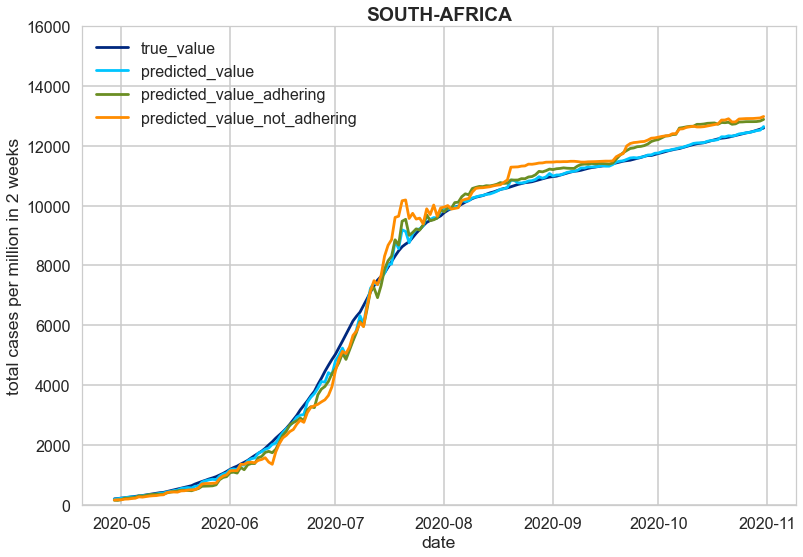

In [63]:
# Plotting settings
sns.set_style("whitegrid")
plt.style.use('seaborn-poster')
slides_palette_four = ["#00287f", "#00c5ff","#6B8E23","#FF8C00"]
sns.set_palette(slides_palette_four)

g1 = sns.lineplot(data=pivot_sth_african_data, x='date', y='cases', hue='value_type');
g1.set_title('SOUTH-AFRICA', weight='bold');
g1.set_xlabel('date');
g1.set_ylabel('total cases per million in 2 weeks');
g1.set_ylim(0,16000)
g1.legend().set_title('');
g1.legend(loc='upper left');